<a href="https://colab.research.google.com/github/MirHafiz/CVPR/blob/main/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2
import PIL.Image as Image
import os
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)

228827136/228813984 [==============================] - 1s 0us/step


In [ ]:
data_dir

'./datasets/flower_photos'

In [ ]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

In [ ]:
list(data_dir.glob('daisy/*'))[:5]

[PosixPath('datasets/flower_photos/daisy/7630511450_02d3292e90.jpg'),
 PosixPath('datasets/flower_photos/daisy/1879567877_8ed2a5faa7_n.jpg'),
 PosixPath('datasets/flower_photos/daisy/14621687774_ec52811acd_n.jpg'),
 PosixPath('datasets/flower_photos/daisy/6095817094_3a5b1d793d.jpg'),
 PosixPath('datasets/flower_photos/daisy/1342002397_9503c97b49.jpg')]

In [ ]:
roses = list(data_dir.glob('roses/*'))
roses[:5]

[PosixPath('datasets/flower_photos/roses/12323085443_8ac0cdb713_n.jpg'),
 PosixPath('datasets/flower_photos/roses/16149016979_23ef42b642_m.jpg'),
 PosixPath('datasets/flower_photos/roses/5061135742_2870a7b691_n.jpg'),
 PosixPath('datasets/flower_photos/roses/1801614110_bb9fa46830.jpg'),
 PosixPath('datasets/flower_photos/roses/16051111039_0f0626a241_n.jpg')]

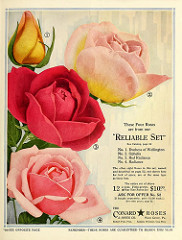

In [ ]:
import PIL
PIL.Image.open(str(roses[1]))

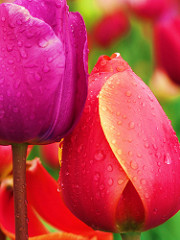

In [ ]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

In [ ]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [ ]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [ ]:
X, y = [], []
IMG_SHAPE = (224,224)

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,IMG_SHAPE)
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [ ]:
X = np.array(X)
y = np.array(y)

In [ ]:
print(X.shape)
print(y.shape)

Train 

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

Normalization

In [ ]:
X_train_scaled = X_train/255
X_test_scaled = X_test/255

**Loading pre-trained classifier(mobilenet_v2) from tensorflow hub**

In [ ]:
classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMG_SHAPE+(3,))
])

**Collecting the weights of pre-trained model, removing the top layer and freezing the model**

In [ ]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

**Adding a dense layer for classifying 5 classes to the pre-trained model**

In [ ]:
num_of_flowers = 5

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_flowers)
])

model.summary()

**Trainning the model**

In [ ]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

h = model.fit(x=X_train_scaled, y=y_train, 
              epochs=5, 
              validation_split=0.2,
             )

Epoch 1/5
69/69 [==============================] - 77s 1s/step - loss: 0.8880 - accuracy: 0.6606 - val_loss: 0.5617 - val_accuracy: 0.7949
Epoch 2/5
69/69 [==============================] - 68s 988ms/step - loss: 0.4420 - accuracy: 0.8442 - val_loss: 0.4754 - val_accuracy: 0.8258
Epoch 3/5
69/69 [==============================] - 67s 974ms/step - loss: 0.3492 - accuracy: 0.8851 - val_loss: 0.4360 - val_accuracy: 0.8312
Epoch 4/5
69/69 [==============================] - 67s 975ms/step - loss: 0.2910 - accuracy: 0.9105 - val_loss: 0.4136 - val_accuracy: 0.8439
Epoch 5/5
69/69 [==============================] - 67s 974ms/step - loss: 0.2549 - accuracy: 0.9259 - val_loss: 0.4118 - val_accuracy: 0.8457


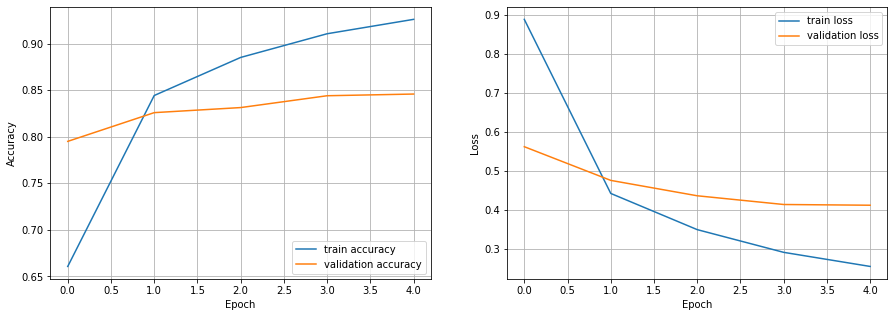

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'], '-', label='train accuracy')
plt.plot(h.history['val_accuracy'], '-', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'], '-', label='train loss')
plt.plot(h.history['val_loss'], '-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

In [ ]:
model.evaluate(X_test_scaled,y_test)